<H1>Overview</H1>

The High Definition-Advanced Imaging Technology (HD-AIT) system files supplied in this contest range in size from 10MB to over 2GB per subject.  With just under 1200 examples, we'll need to figure out how to make or find more and almost any approach will have to substantially reduce the size of the 512x660x16 image data to be fed into a machine learning model.  In the instructions, the organizers suggest that one may even be able to win the contest with one of the smaller image suites. So in this notebook, I take a whack at preprocessing the lowest res images we have and providing some basic building blocks for the preprocessing pipeline.

A quick disclaimer, I'm not an expert on these systems or the related scans.  If you see something I've misunderstood or you think I've made an error, let me know and I'll correct it.  This contest is aimed at a critical problem.  I'm in this to help us get better at threat detection.  The community can definitely improve the predictive veracity of these scans.  Anyway, I'm excited to get going so let's jump in.  

To begin I collect all of the imports used in the notebook at the top.  It makes it easier when you're converting to a preprocessing script.

In [61]:
# imports
from __future__ import print_function
from __future__ import division
import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import scipy
import scipy.ndimage
import scipy.misc


%matplotlib inline


Next I collect the constants.  You'll need to replace the various file name reference constants with a path to your corresponding folder structure.

In [2]:
# constants
COLORMAP = 'pink'
APS_FILE_NAME = '../stage1_aps/00360f79fd6e02781457eda48f85da90.aps'
BODY_ZONES = '../body_zones.png'
THREAT_LABELS = '../labels/stage1_labels.csv'

<H3>Analyzing Threat Zones</H3>

The scans to be analyzed in this contest all segment the body into numbered "threat zones".  Your modeling and results will have to give probability of contraband within a given threat zone.  The contest sponsors included a  visualization of the threat zones and the corresponding numbering scheme.  (Note that you will need to uncomment the code in the next block for it to run in your own environment)

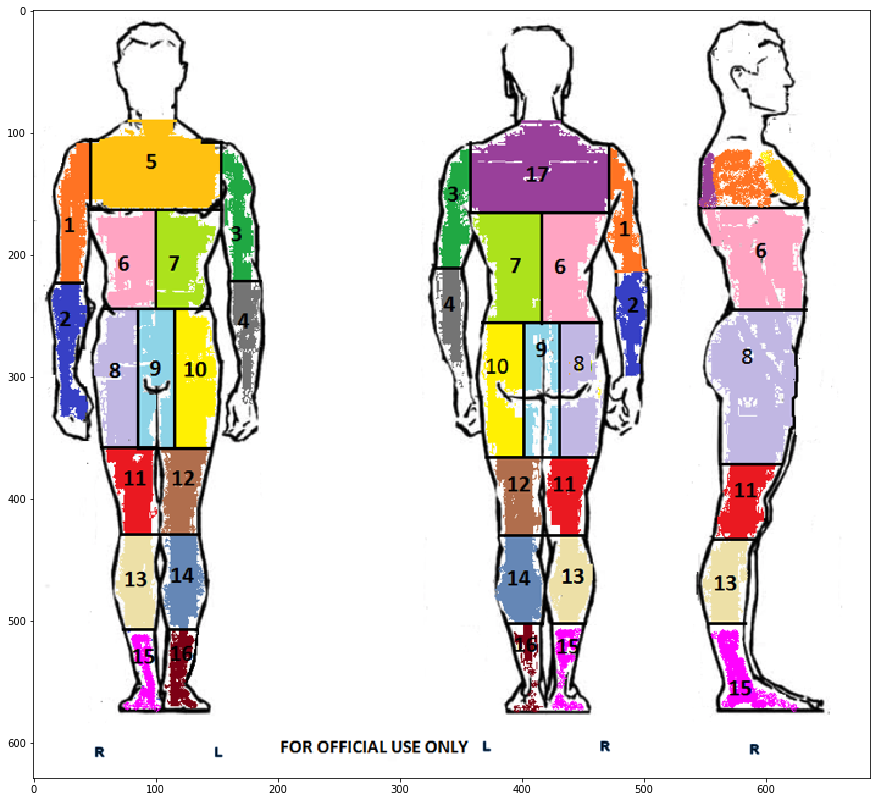

In [3]:
# show the threat zones
body_zones_img = plt.imread(BODY_ZONES)
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(body_zones_img)



*Output removed by request of DHS.  Run in your own environment to review threat zones.*

<H3>Segmenting and Cropping the Scans</H3>

The .aps version of the scans are images (sometimes refered to herein also as slices) with views from shots taken at a regular interval of 22.5-degree rotation, 360 degrees around the subject scanned.  So for each subject, we'll get 16 scans. Each scan will contain a view from a given angle of any visible threat zones.  

Part of my approach in this notebook is to isolate each individual threat zone from every visible angle.  Later, I want to be able to make features out of each individual threat zone from each angle that a given threat zone is visible. That will allow me to later train on each threat zone individually from every view in a 2D format.

Each image (or slice) is 512 x 660 pixels. Since I will want to be able to isolate each threat zone, I divide the full image into "sectors".  

In the [0] image (the one that is face forward, the leftmost figure in the visualization above) the sector numbers used below correspond to the threat zone number.  But as the images in the sequence rotate around the subject, threat zones may be visible from another sector.  Below, we'll use these vertices to capture isolated views of a given threat zone.

Once the scans have been masked, then they can be cropped to reduce the size of the image.  The crop dimensions make 250x250 scans and are included in sector_crop_list.

In [4]:
# Divide the available space on an image into 16 sectors. In the [0] image these
# zones correspond to the TSA threat zones.  But on rotated images, the slice
# list uses the sector that best shows the threat zone
sector01_pts = np.array([[0,160],[200,160],[200,230],[0,230]], np.int32)
sector02_pts = np.array([[0,0],[200,0],[200,160],[0,160]], np.int32)
sector03_pts = np.array([[330,160],[512,160],[512,240],[330,240]], np.int32)
sector04_pts = np.array([[350,0],[512,0],[512,160],[350,160]], np.int32)

# sector 5 is used for both threat zone 5 and 17
sector05_pts = np.array([[0,220],[512,220],[512,300],[0,300]], np.int32) 

sector06_pts = np.array([[0,300],[256,300],[256,360],[0,360]], np.int32)
sector07_pts = np.array([[256,300],[512,300],[512,360],[256,360]], np.int32)
sector08_pts = np.array([[0,370],[225,370],[225,450],[0,450]], np.int32)
sector09_pts = np.array([[225,370],[275,370],[275,450],[225,450]], np.int32)
sector10_pts = np.array([[275,370],[512,370],[512,450],[275,450]], np.int32)
sector11_pts = np.array([[0,450],[256,450],[256,525],[0,525]], np.int32)
sector12_pts = np.array([[256,450],[512,450],[512,525],[256,525]], np.int32)
sector13_pts = np.array([[0,525],[256,525],[256,600],[0,600]], np.int32)
sector14_pts = np.array([[256,525],[512,525],[512,600],[256,600]], np.int32)
sector15_pts = np.array([[0,600],[256,600],[256,660],[0,660]], np.int32)
sector16_pts = np.array([[256,600],[512,600],[512,660],[256,660]], np.int32)

# crop dimensions, upper left x, y, width, height
sector_crop_list = [[ 50,  50, 250, 250], # sector 1
                    [  0,   0, 250, 250], # sector 2
                    [ 50, 250, 250, 250], # sector 3
                    [250,   0, 250, 250], # sector 4
                    [150, 150, 250, 250], # sector 5/17
                    [200, 100, 250, 250], # sector 6
                    [200, 150, 250, 250], # sector 7
                    [250,  50, 250, 250], # sector 8
                    [250, 150, 250, 250], # sector 9
                    [300, 200, 250, 250], # sector 10
                    [400, 100, 250, 250], # sector 11
                    [350, 200, 250, 250], # sector 12
                    [410,   0, 250, 250], # sector 13
                    [410, 200, 250, 250], # sector 14
                    [410,   0, 250, 250], # sector 15
                    [410, 200, 250, 250], # sector 16
                   ]

<H3>Threat Zone Slice Lists and Crop Lists</H3>

For each zone, we pick the sector with the best view of that threat zone.  Since there are 16 images per subject, each zone's slice list contains 16 entries each naming the sector where the given threat zone is best visible.  At some angles, a given threat zone may not be visible.  We just set those values to None so that its easy to iterate the list and ignore the scans where a given zone is not visible.  

In this notebook, I call this a threat zone slice list.  To create a feature for a given threat zone, I'll iterate this list and use the vertices to establish a region of interest and mask off the threat zone.  Hopefully that's clear.  If not it will be more clear below.

I use the same technique to then crop the segmented images to reduce the size.

Also its worth noting, that I haven't yet extensively tested to make sure that there is no clipping.  If someone finds a more optimal set of vertices or notes meaningful clipping, please post it in the discussion.

In [5]:
# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_slice_list = [ [ # threat zone 1
                      sector01_pts, sector01_pts, sector01_pts, None, 
                      None, None, sector03_pts, sector03_pts, 
                      sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts, sector01_pts ], 
    
                    [ # threat zone 2
                      sector02_pts, sector02_pts, sector02_pts, None, 
                      None, None, sector04_pts, sector04_pts, 
                      sector04_pts, sector04_pts, sector04_pts, None, 
                      None, sector02_pts, sector02_pts, sector02_pts ],
    
                    [ # threat zone 3
                      sector03_pts, sector03_pts, sector03_pts, sector03_pts, 
                      None, None, sector01_pts, sector01_pts,
                      sector01_pts, sector01_pts, sector01_pts, sector01_pts, 
                      None, None, sector03_pts, sector03_pts ],
    
                    [ # threat zone 4
                      sector04_pts, sector04_pts, sector04_pts, sector04_pts, 
                      None, None, sector02_pts, sector02_pts, 
                      sector02_pts, sector02_pts, sector02_pts, sector02_pts, 
                      None, None, sector04_pts, sector04_pts ],
    
                    [ # threat zone 5
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts,
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 6
                      sector06_pts, None, None, None, 
                      None, None, None, None, 
                      sector07_pts, sector07_pts, sector06_pts, sector06_pts, 
                      sector06_pts, sector06_pts, sector06_pts, sector06_pts ],
    
                    [ # threat zone 7
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      sector07_pts, sector07_pts, sector07_pts, sector07_pts, 
                      None, None, None, None, 
                      None, None, None, None ],
    
                    [ # threat zone 8
                      sector08_pts, sector08_pts, None, None, 
                      None, None, None, sector10_pts, 
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector08_pts, sector08_pts, sector08_pts, sector08_pts ],
    
                    [ # threat zone 9
                      sector09_pts, sector09_pts, sector08_pts, sector08_pts, 
                      sector08_pts, None, None, None,
                      sector09_pts, sector09_pts, None, None, 
                      None, None, sector10_pts, sector09_pts ],
    
                    [ # threat zone 10
                      sector10_pts, sector10_pts, sector10_pts, sector10_pts, 
                      sector10_pts, sector08_pts, sector10_pts, None, 
                      None, None, None, None, 
                      None, None, None, sector10_pts ],
    
                    [ # threat zone 11
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts, 
                      None, None, sector12_pts, sector12_pts,
                      sector12_pts, sector12_pts, sector12_pts, None, 
                      sector11_pts, sector11_pts, sector11_pts, sector11_pts ],
    
                    [ # threat zone 12
                      sector12_pts, sector12_pts, sector12_pts, sector12_pts, 
                      sector12_pts, sector11_pts, sector11_pts, sector11_pts, 
                      sector11_pts, sector11_pts, sector11_pts, None, 
                      None, sector12_pts, sector12_pts, sector12_pts ],
    
                    [ # threat zone 13
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts, 
                      None, None, sector14_pts, sector14_pts,
                      sector14_pts, sector14_pts, sector14_pts, None, 
                      sector13_pts, sector13_pts, sector13_pts, sector13_pts ],
    
                    [ # sector 14
                      sector14_pts, sector14_pts, sector14_pts, sector14_pts, 
                      sector14_pts, None, sector13_pts, sector13_pts, 
                      sector13_pts, sector13_pts, sector13_pts, None, 
                      None, None, None, None ],
    
                    [ # threat zone 15
                      sector15_pts, sector15_pts, sector15_pts, sector15_pts, 
                      None, None, sector16_pts, sector16_pts,
                      sector16_pts, sector16_pts, None, sector15_pts, 
                      sector15_pts, None, sector15_pts, sector15_pts ],
    
                    [ # threat zone 16
                      sector16_pts, sector16_pts, sector16_pts, sector16_pts, 
                      sector16_pts, sector16_pts, sector15_pts, sector15_pts, 
                      sector15_pts, sector15_pts, sector15_pts, None, 
                      None, None, sector16_pts, sector16_pts ],
    
                    [ # threat zone 17
                      None, None, None, None, 
                      None, None, None, None,
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts, 
                      sector05_pts, sector05_pts, sector05_pts, sector05_pts ] ]

# Each element in the zone_slice_list contains the sector to use in the call to roi()
zone_crop_list =  [ [ # threat zone 1
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], None, 
                      None, None, sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], None, 
                      None, sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0] ],
    
                    [ # threat zone 2
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], None, 
                      None, None, sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      None, None, sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1] ],
    
                    [ # threat zone 3
                      sector_crop_list[2], sector_crop_list[2], sector_crop_list[2], 
                      sector_crop_list[2], None, None, sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], sector_crop_list[0], 
                      sector_crop_list[0], sector_crop_list[0], None, None, 
                      sector_crop_list[2], sector_crop_list[2] ],
               
                    [ # threat zone 4
                      sector_crop_list[3], sector_crop_list[3], sector_crop_list[3], 
                      sector_crop_list[3], None, None, sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], sector_crop_list[1], 
                      sector_crop_list[1], sector_crop_list[1], None, None, 
                      sector_crop_list[3], sector_crop_list[3] ],
                    
                    [ # threat zone 5
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4],
                      None, None, None, None, None, None, None, None ],
                    
                    [ # threat zone 6
                      sector_crop_list[5], None, None, None, None, None, None, None, 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5], sector_crop_list[5], 
                      sector_crop_list[5], sector_crop_list[5] ],
    
                    [ # threat zone 7
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], sector_crop_list[6], 
                      sector_crop_list[6], sector_crop_list[6], 
                      None, None, None, None, None, None, None, None ],
    
                    [ # threat zone 8
                      sector_crop_list[7], sector_crop_list[7], None, None, None, 
                      None, None, sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[7], sector_crop_list[7], sector_crop_list[7], 
                      sector_crop_list[7] ],
    
                    [ # threat zone 9
                      sector_crop_list[8], sector_crop_list[8], sector_crop_list[7], 
                      sector_crop_list[7], sector_crop_list[7], None, None, None,
                      sector_crop_list[8], sector_crop_list[8], None, None, None, 
                      None, sector_crop_list[9], sector_crop_list[8] ],
    
                    [ # threat zone 10
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[9], 
                      sector_crop_list[9], sector_crop_list[9], sector_crop_list[7], 
                      sector_crop_list[9], None, None, None, None, None, None, None, 
                      None, sector_crop_list[9] ],
    
                    [ # threat zone 11
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10], 
                      sector_crop_list[10], None, None, sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], None, sector_crop_list[10], 
                      sector_crop_list[10], sector_crop_list[10], sector_crop_list[10] ],
    
                    [ # threat zone 12
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11], 
                      sector_crop_list[11], sector_crop_list[11], None, None, 
                      sector_crop_list[11], sector_crop_list[11], sector_crop_list[11] ],
    
                    [ # threat zone 13
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12], 
                      sector_crop_list[12], None, None, sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], None, sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], sector_crop_list[12] ],
    
                    [ # sector 14
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[13], 
                      sector_crop_list[13], sector_crop_list[13], None, 
                      sector_crop_list[13], sector_crop_list[13], sector_crop_list[12], 
                      sector_crop_list[12], sector_crop_list[12], None, None, None, 
                      None, None ],
    
                    [ # threat zone 15
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], None, None, sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      None, sector_crop_list[14], sector_crop_list[14], None, 
                      sector_crop_list[14], sector_crop_list[14] ],
    
                    [ # threat zone 16
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[15], sector_crop_list[15], sector_crop_list[15], 
                      sector_crop_list[14], sector_crop_list[14], sector_crop_list[14], 
                      sector_crop_list[14], sector_crop_list[14], None, None, None, 
                      sector_crop_list[15], sector_crop_list[15] ],
    
                    [ # threat zone 17
                      None, None, None, None, None, None, None, None,
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4], sector_crop_list[4], 
                      sector_crop_list[4], sector_crop_list[4] ] ]


<H3>For What its Worth</H3>

I recognize that this is a pretty inexact and brute force-ish way to segment the data, but I tried a variety of other techniques (canny, different combos of erosion/dilation, and cv2.findContours) to recognize the shape and size of the threat zones in the data, and found these unreliable.  I am new to much of this, so if someone has a more sophisticated approach to segmentation, I hope you'll post in the discussion and we can incorporate it.  Its also worth noting that I did not exhaust the parameter tuning or combinations of these techniques, so if someone has knowledge/expertise with those transformations, its is an area for expansion.  Other ideas welcome!

<H3>Incorporating Cukierski</H3>

In any event, next I incorporate William Cukierski's read_header(...) and read_images(...) from the <A HREF="http://www.kaggle.com/tsa/notebook.html">Reading Images notebook</A>.  Special thanks to William for hammering through that long list of parameters in the header and for the whizbang image reader!  

If anyone knows where there is documentation for all of those header features, post it in the discussion.  I assume its all basically unhelpful, but I am new to this data so I don't really know.

Also extra thanks to William for showing me np.flipud().  That's a new one for me!  Definitely will be using that one in the future.


In [6]:
#----------------------------------------------------------------------------------
# read_header(infile):  takes an aps file and creates a dict of the data
#
# infile:               an aps file
#
# returns:              all of the fields in the header
#----------------------------------------------------------------------------------

def read_header(infile):
    # declare dictionary
    h = dict()
    
    with open(infile, 'r+b') as fid:

        h['filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['parent_filename'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 20))
        h['comments1'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['comments2'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 80))
        h['energy_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['config_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['file_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['trans_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['date_modified'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 16))
        h['frequency'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['mat_velocity'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_polarization_channels'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare00'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['adc_min_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_max_voltage'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['band_width'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare01'] = np.fromfile(fid, dtype = np.int16, count = 5)
        h['polarization_type'] = np.fromfile(fid, dtype = np.int16, count = 4)
        h['record_header_size'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['word_precision'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['min_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['max_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['avg_data_value'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_scale_factor'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['data_units'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['surf_removal'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['edge_weighting'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['x_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['y_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['z_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['t_units'] = np.fromfile(fid, dtype = np.uint16, count = 1)
        h['spare02'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_return_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['scan_orientation'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scan_direction'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['data_storage_order'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['x_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_inc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['num_x_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_y_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_z_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['num_t_pts'] = np.fromfile(fid, dtype = np.int32, count = 1)
        h['x_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_speed'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_acc'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_motor_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_encoder_res'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['date_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['time_processed'] = b''.join(np.fromfile(fid, dtype = 'S1', count = 8))
        h['depth_recon'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['elevation_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['roll_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_max_travel'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['azimuth_offset_angle'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['adc_type'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['spare06'] = np.fromfile(fid, dtype = np.int16, count = 1)
        h['scanner_radius'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['x_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['y_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['z_offset'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['t_delay'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_start'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['range_gate_end'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['ahis_software_version'] = np.fromfile(fid, dtype = np.float32, count = 1)
        h['spare_end'] = np.fromfile(fid, dtype = np.float32, count = 10)

    return h
  
#unit test ----------------------------------
header = read_header(APS_FILE_NAME)

for data_item in sorted(header):
    print ('{} -> {}'.format(data_item, header[data_item]))

adc_max_voltage -> [ 1.10000002]
adc_min_voltage -> [-1.10000002]
adc_type -> [17]
ahis_software_version -> [ 7.0999999]
avg_data_value -> [ 2857.20166016]
azimuth_offset_angle -> [ 0.]
band_width -> [ 30058.70898438]
comments1 -> b'                                                                                '
comments2 -> b'                                                                                '
config_type -> [2]
data_scale_factor -> [  1.97193906e-08]
data_storage_order -> [9]
data_type -> [5]
data_units -> [0]
date_modified -> b''
date_processed -> b''
depth_recon -> [ 0.]
edge_weighting -> [0]
elevation_offset_angle -> [ 0.]
energy_type -> [2]
file_type -> [12]
filename -> b'                    '
frequency -> [ 25000.]
mat_velocity -> [  3.00000000e+08]
max_data_value -> [ 65535.]
min_data_value -> [ 0.]
num_polarization_channels -> [1]
num_pts -> [1]
num_t_pts -> [16]
num_x_pts -> [512]
num_y_pts -> [660]
num_z_pts -> [1]
parent_filename -> b'                    '
pol

<H3>Style/Use Note</H3>

From a style perspective, I like to stick a unit test at the bottom of a function or code block.  I find it especially helpful when debugging.  Since there is no contest scan data on Kaggle, I've commented the unit tests out.  If you want to run it in your own environment, you'll want to uncomment these.

In [7]:
#----------------------------------------------------------------------------------
# read_data(infile):  reads and rescales any of the four image types
#
# infile:             an .aps, .aps3d, .a3d, or ahi file
#
# returns:            the stack of images
#
# note:               word_type == 7 is an np.float32, word_type == 4 is np.uint16      
#----------------------------------------------------------------------------------

def read_data(infile):
    
    # read in header and get dimensions
    h = read_header(infile)
    nx = int(h['num_x_pts'])
    ny = int(h['num_y_pts'])
    nt = int(h['num_t_pts'])
    
    extension = os.path.splitext(infile)[1]
    
    with open(infile, 'rb') as fid:
          
        # skip the header
        fid.seek(512) 

        # handle .aps and .a3aps files
        if extension == '.aps' or extension == '.a3daps':
        
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)

            elif(h['word_type']==4): 
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor'] 
            data = data.reshape(nx, ny, nt, order='F').copy()

        # handle .a3d files
        elif extension == '.a3d':
              
            if(h['word_type']==7):
                data = np.fromfile(fid, dtype = np.float32, count = nx * ny * nt)
                
            elif(h['word_type']==4):
                data = np.fromfile(fid, dtype = np.uint16, count = nx * ny * nt)

            # scale and reshape the data
            data = data * h['data_scale_factor']
            data = data.reshape(nx, nt, ny, order='F').copy() 
            
        # handle .ahi files
        elif extension == '.ahi':
            data = np.fromfile(fid, dtype = np.float32, count = 2* nx * ny * nt)
            data = data.reshape(2, ny, nx, nt, order='F').copy()
            real = data[0,:,:,:].copy()
            imag = data[1,:,:,:].copy()

        if extension != '.ahi':
            return data
        else:
            return real, imag

#unit test ----------------------------------
d = read_data(APS_FILE_NAME)

<H2>Basic Descriptive Probabilities for Each Threat Zone </H2>

The labels provided in the contest treat the subject number and threat zone as a combined label.  But to calculate the descriptive stats I want to separate them so that we can get total counts for each threat zone.  Also, in this preprocessing approach, we will make individual examples out of each threat zone treating each threat zone as a separate model.  The next three functions work with this data.

In [8]:
#----------------------------------------------------------------------------------------
# get_hit_rate_stats(infile):  gets the threat probabilities in a useful form
#
# infile:                      labels csv file
#
# returns:                     a dataframe of the summary hit probabilities
#
#----------------------------------------------------------------------------------------

def get_hit_rate_stats(infile):
    # pull the labels for a given patient
    df = pd.read_csv(infile)

    # Separate the zone and patient id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]

    # make a df of the sums and counts by zone and calculate hit rate per zone, then sort high to low
    df_summary = df.groupby('Zone')['Probability'].agg(['sum','count'])
    df_summary['Zone'] = df_summary.index
    df_summary['pct'] = df_summary['sum'] / df_summary['count']
    df_summary.sort_values('pct', axis=0, ascending= False, inplace=True)
    
    return df_summary

# unit test -----------------------
df = get_hit_rate_stats(THREAT_LABELS)
df.head()

,sum,count,Zone,pct
Zone,,,,
Zone1,133,1147,Zone1,0.115955
Zone2,126,1147,Zone2,0.109852
Zone8,124,1147,Zone8,0.108108
Zone14,122,1147,Zone14,0.106364
Zone15,118,1147,Zone15,0.102877


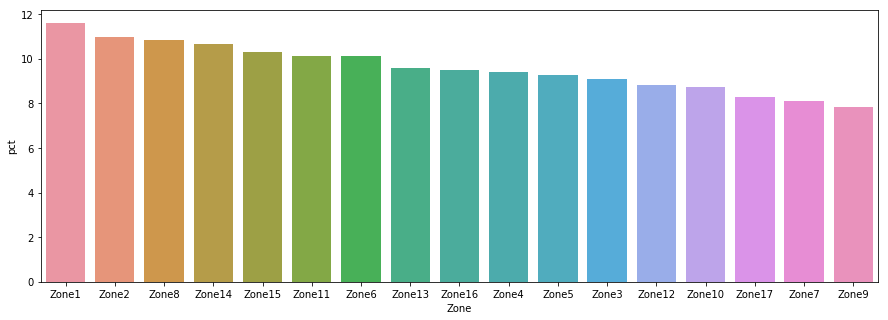

running


In [9]:
#------------------------------------------------------------------------------------------
# chart_hit_rate_stats(df_summary): charts threat probabilities in desc order by zone
#
# df_summary:                 a dataframe like that returned from get_hit_rate_stats(...)
#
#-------------------------------------------------------------------------------------------

def chart_hit_rate_stats(df_summary):
    fig, ax = plt.subplots(figsize=(15,5))
    plt.show(sns.barplot(ax=ax, x=df_summary['Zone'], y=df_summary['pct']*100))

# unit test ------------------
chart_hit_rate_stats(df)
print ("running")

In [10]:
#------------------------------------------------------------------------------------------
# print_hit_rate_stats(df_summary): lists threat probabilities by zone
#
# df_summary:               a dataframe like that returned from get_hit_rate_stats(...)
#
#------------------------------------------------------------------------------------------

def print_hit_rate_stats(df_summary):
    # print the table of values readbly
    print ('{:6s}   {:>4s}   {:6s}'.format('Zone', 'Hits', 'Pct %'))
    print ('------   ----- ----------')
    for zone in df_summary.iterrows():
        print ('{:6s}   {:>4d}   {:>6.3f}%'.format(zone[0], np.int16(zone[1]['sum']), zone[1]['pct']*100))
    print ('------   ----- ----------')
    print ('{:6s}   {:>4d}   {:6.3f}%'.format('Total ', np.int16(df_summary['sum'].sum(axis=0)), 
                                             ( df_summary['sum'].sum(axis=0) / df_summary['count'].sum(axis=0))*100))

# unit test -----------------------
print_hit_rate_stats(df)

Zone     Hits   Pct % 
------   ----- ----------
Zone1     133   11.595%
Zone2     126   10.985%
Zone8     124   10.811%
Zone14    122   10.636%
Zone15    118   10.288%
Zone11    116   10.113%
Zone6     116   10.113%
Zone13    110    9.590%
Zone16    109    9.503%
Zone4     108    9.416%
Zone5     106    9.241%
Zone3     104    9.067%
Zone12    101    8.806%
Zone10    100    8.718%
Zone17     95    8.282%
Zone7      93    8.108%
Zone9      90    7.847%
------   ----- ----------
Total    1871    9.595%


![Hit Rate Stats List][1]


  [1]: https://storage.googleapis.com/kaggle-datasets-jbf/tsa_datasets/hitratestats.png

<H3>Zone 1?  Really?</H3>

Looking at this distribution I'm left to wonder whether the stage 2 data might be substantially different, and certainly one might think real world data would be different.  Zone 1, the right arm, seems unlikely to be the population's most likely zone to hide contraband.  To begin with, you would have to put your  contraband in place with your left hand.  So unless most airline passengers that carry contraband are left handed, I am guessing that the real world (and perhaps stage 2) will look different.  Its just a guess of course...  Anyway, I am convinced it will be important to figure out how to get as many examples by threat zone as possible.

In any event, it will also be handy to easily get a list of zones and probabilities from the labels file, so I added this in here.  Note that the subject has contraband in zone 14 (left leg).  We'll keep an eye out for that!

In [11]:
#----------------------------------------------------------------------------------------
# def get_subject_labels(infile, subject_id): lists threat probabilities by zone
#
# infile:                          labels csv file
#
# subject_id:                      the individual you want the threat zone labels for
#
# returns:                         a df with the list of zones and contraband (0 or 1)
#
#---------------------------------------------------------------------------------------

def get_subject_labels(infile, subject_id):

    # read labels into a dataframe
    df = pd.read_csv(infile)

    # Separate the zone and subject id into a df
    df['Subject'], df['Zone'] = df['Id'].str.split('_',1).str
    df = df[['Subject', 'Zone', 'Probability']]
    threat_list = df.loc[df['Subject'] == subject_id]
    
    return threat_list
    

    
# unit test ----------------------------------------------------------------------
print(get_subject_labels(THREAT_LABELS, '00360f79fd6e02781457eda48f85da90'))

                             Subject    Zone  Probability
0   00360f79fd6e02781457eda48f85da90   Zone1            0
1   00360f79fd6e02781457eda48f85da90  Zone10            0
2   00360f79fd6e02781457eda48f85da90  Zone11            0
3   00360f79fd6e02781457eda48f85da90  Zone12            0
4   00360f79fd6e02781457eda48f85da90  Zone13            0
5   00360f79fd6e02781457eda48f85da90  Zone14            1
6   00360f79fd6e02781457eda48f85da90  Zone15            0
7   00360f79fd6e02781457eda48f85da90  Zone16            0
8   00360f79fd6e02781457eda48f85da90  Zone17            0
9   00360f79fd6e02781457eda48f85da90   Zone2            0
10  00360f79fd6e02781457eda48f85da90   Zone3            0
11  00360f79fd6e02781457eda48f85da90   Zone4            0
12  00360f79fd6e02781457eda48f85da90   Zone5            0
13  00360f79fd6e02781457eda48f85da90   Zone6            0
14  00360f79fd6e02781457eda48f85da90   Zone7            0
15  00360f79fd6e02781457eda48f85da90   Zone8            0
16  00360f79fd

![Subject Threat List][1]


  [1]: https://storage.googleapis.com/kaggle-datasets-jbf/tsa_datasets/subject_threat_list.png

In [12]:
#------------------------------------------------------------------------------------------------
# get_subject_zone_label(zone_num, df):    gets a label for a given subject and zone
#
# zone_num:                                a 0 based threat zone index
#
# df:                                      a df like that returned from get_subject_labels(...)
#
# returns:                                 [0,1] if contraband is present, [1,0] if it isnt
#
#-----------------------------------------------------------------------------------------------

def get_subject_zone_label(zone_num, df):
    
    # Dict to convert a 0 based threat zone index to the text we need to look up the label
    zone_index = {0: 'Zone1', 1: 'Zone2', 2: 'Zone3', 3: 'Zone4', 4: 'Zone5', 5: 'Zone6', 
                  6: 'Zone7', 7: 'Zone8', 8: 'Zone9', 9: 'Zone10', 10: 'Zone11', 11: 'Zone12', 
                  12: 'Zone13', 13: 'Zone14', 14: 'Zone15', 15: 'Zone16',
                  16: 'Zone17'
                 }
    # get the text key from the dictionary
    key = zone_index.get(zone_num)
    
    # select the probability value and make the label
    if df.loc[df['Zone'] == key]['Probability'].values[0] == 1:
        # threat present
        return [0,1]
    else:
        #no threat present
        return [1,0]

    
# unit test --------------------------------
label = get_subject_zone_label(13, get_subject_labels(THREAT_LABELS, '00360f79fd6e02781457eda48f85da90'))
print (np.array(label))

[0 1]


<H3>Viewing and Selecting Images</H3>

I always like to actually see the data before I start messing with it.  So this next function prints a nice, but small 4x4 matrix of the 16 images.  Since I did this originally in Google Datalab, there is an output size constraint that this function hits.  So I used a cv2.resize to get it under the wire.  Since there is no data on Kaggle it doesn't matter for this notebook.  But watch out for this if you run it yourself.  If your environment does not have the same size constraint, show the images full size.  Its good grounding.  After you've seen them once, you can comment out the unit test.  Note also that this only applies the unit test and visualization.


In [372]:
def convert_to_grayscale(img):
    # scale pixel values to grayscale
    base_range = np.amax(img) - np.amin(img)
    rescaled_range = 255 - 0
    img_rescaled = (((img - np.amin(img)) * rescaled_range) / base_range)

    return np.uint8(img_rescaled)

def spread_spectrum(img):
    img = stats.threshold(img, threshmin=12, newval=0)
    
    # see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img= clahe.apply(img)
    
    return img


def crop_and_resize_2D(data, x_resize_ratio = 1.0):
    
    print (data.shape)
    print (len(data))
    print (len(data[0]))
    
    max_y = 0
    min_y = len(data)
    max_x = 0
    min_x = len(data[0])

    for y in range(0, len(data)):
        for x in range(0, len(data[y])):
            #print (data[y][x])
            if data[y][x] > 0.00015:
                #print ("made it in!")
                if x > max_x: max_x = x
                if x < min_x: min_x = x
                if y > max_y: max_y = y
                if y < min_y: min_y = y

    cropped_data = data[min_y:max_y, min_x:max_x]                   

    x_ratio = len(data[0]) / (max_x - min_x) * x_resize_ratio
    y_ratio = len(data) / (max_y - min_y)

    print ("ratios: " + str(x_ratio) + " " + str(y_ratio))

    return scipy.ndimage.zoom(cropped_data, (y_ratio, x_ratio))

resized_ims = []    
def prep_im(infile):
    img = read_data(infile)
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()


    print(len(img))
        
    new_img = img
    #new_img = np.flip(img, axis=2)
    img = new_img

    for i in range(0, 16):
        if i==3 or i==5 or i==11 or i==13:
            resized_ims.append(crop_and_resize_2D(img[i], x_resize_ratio=0.75))
        elif i==4 or i==12:
            resized_ims.append(crop_and_resize_2D(img[i], x_resize_ratio=0.5))
        else:
            resized_ims.append(crop_and_resize_2D(img[i]))

    for i in range(0, len(resized_ims)):
        resized_ims[i] = convert_to_grayscale(resized_ims[i])
        resized_ims[i] = spread_spectrum(resized_ims[i])
        
        

APS_FILE_NAME = '../stage1_aps/1835b242ed6c519cc0017cdd5b08aa9b.aps'
#Zone 15
#0b8d4ebeeb72a935257f364d36619df1
#098f5cfcf6faefd3011a94719cb03dc5
#006ec59fa59dd80a64c85347eef810c7
#0e34d284cb190a79e3316d1926061bc3
prep_im(APS_FILE_NAME)

16
(660, 512)
660
512
ratios: 1.4797687861271676 1.2359550561797752
(660, 512)
660
512
ratios: 1.5802469135802468 1.2154696132596685
(660, 512)
660
512
ratios: 1.8823529411764706 1.1913357400722022
(660, 512)
660
512
ratios: 2.10989010989011 1.1913357400722022
(660, 512)
660
512
ratios: 1.3763440860215055 1.1978221415607986
(660, 512)
660
512
ratios: 1.6271186440677967 1.206581352833638
(660, 512)
660
512
ratios: 1.8220640569395017 1.2043795620437956
(660, 512)
660
512
ratios: 1.528358208955224 1.233644859813084
(660, 512)
660
512
ratios: 1.4755043227665705 1.2043795620437956
(660, 512)
660
512


/home/james/anaconda3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


ratios: 1.5753846153846154 1.229050279329609
(660, 512)
660
512
ratios: 1.9616858237547892 1.213235294117647
(660, 512)
660
512
ratios: 1.873170731707317 1.2
(660, 512)
660
512
ratios: 2.0317460317460316 1.180679785330948
(660, 512)
660
512
ratios: 1.92964824120603 1.180679785330948
(660, 512)
660
512
ratios: 1.8823529411764706 1.193490054249548
(660, 512)
660
512
ratios: 1.615141955835962 1.2244897959183674


/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


In [373]:
print (len(resized_ims))

16


stage1_aps
                               Subject    Zone  Probability
1666  1835b242ed6c519cc0017cdd5b08aa9b   Zone1            0
1667  1835b242ed6c519cc0017cdd5b08aa9b  Zone10            0
1668  1835b242ed6c519cc0017cdd5b08aa9b  Zone11            0
1669  1835b242ed6c519cc0017cdd5b08aa9b  Zone12            0
1670  1835b242ed6c519cc0017cdd5b08aa9b  Zone13            0
1671  1835b242ed6c519cc0017cdd5b08aa9b  Zone14            0
1672  1835b242ed6c519cc0017cdd5b08aa9b  Zone15            0
1673  1835b242ed6c519cc0017cdd5b08aa9b  Zone16            0
1674  1835b242ed6c519cc0017cdd5b08aa9b  Zone17            1
1675  1835b242ed6c519cc0017cdd5b08aa9b   Zone2            0
1676  1835b242ed6c519cc0017cdd5b08aa9b   Zone3            0
1677  1835b242ed6c519cc0017cdd5b08aa9b   Zone4            0
1678  1835b242ed6c519cc0017cdd5b08aa9b   Zone5            0
1679  1835b242ed6c519cc0017cdd5b08aa9b   Zone6            1
1680  1835b242ed6c519cc0017cdd5b08aa9b   Zone7            0
1681  1835b242ed6c519cc0017cd

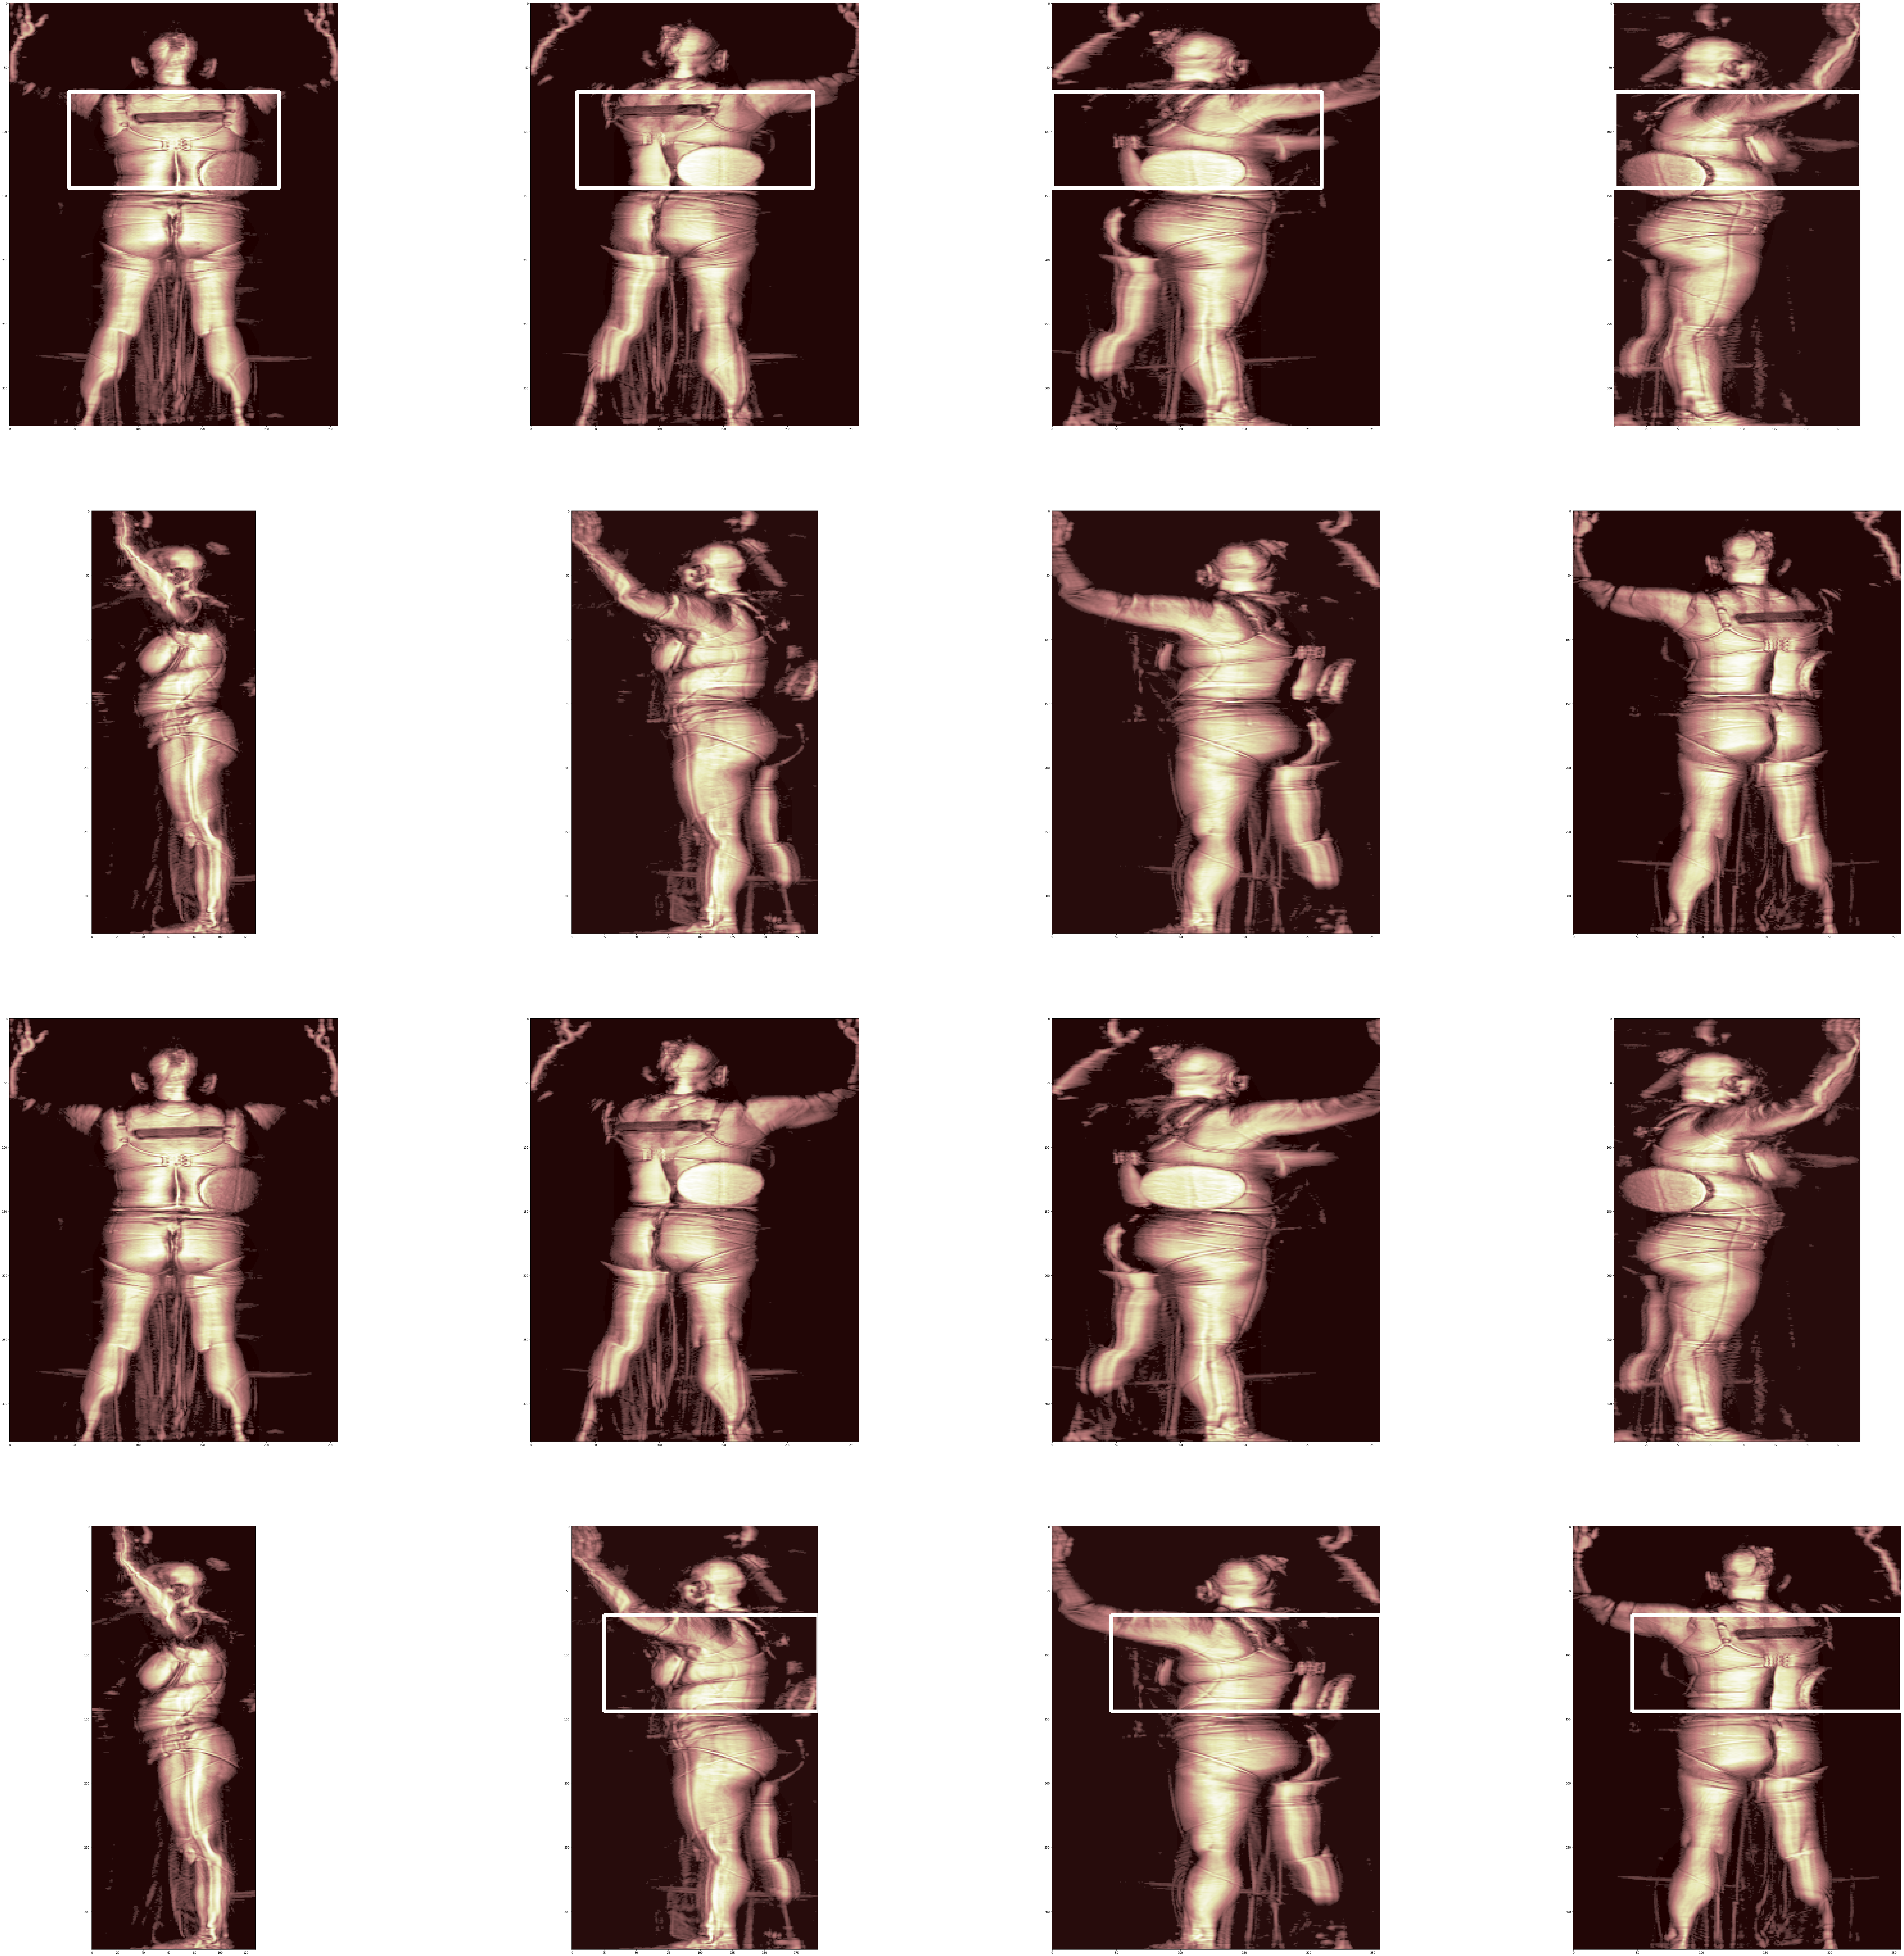

In [374]:


def show_zone(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(0,0),(128, 60),(0.001),1)
    elif slice_num == 1:
        return cv2.rectangle(img,(0,0),(128, 60),(0.001),1)
    elif slice_num == 2:
        return cv2.rectangle(img,(0,0),(128, 60),(0.001),1)
    elif slice_num == 3:
        return cv2.rectangle(img,(0,0),(160, 60),(0.001),1)
    elif slice_num == 5:
        return cv2.rectangle(img,(160,0),(256, 60),(0.001),1)
    elif slice_num == 6:
        return cv2.rectangle(img,(140,0),(256, 60),(0.001),1)
    elif slice_num == 7:
        return cv2.rectangle(img,(128,0),(256, 60),(0.001),1)
    elif slice_num == 8:
        return cv2.rectangle(img,(130,0),(256, 60),(0.001),1)
    elif slice_num == 9:
        return cv2.rectangle(img,(120,0),(256, 60),(0.001),1)
    elif slice_num == 10:
        return cv2.rectangle(img,(100,0),(256, 60),(0.001),1)
    elif slice_num == 11:
        return cv2.rectangle(img,(75,0),(256, 60),(0.001),1)
    elif slice_num == 12:
        return cv2.rectangle(img,(0,0),(256, 60),(0.001),1)
    elif slice_num == 13:
        return cv2.rectangle(img,(0,0),(120, 60),(0.001),1)
    elif slice_num == 14:
        return cv2.rectangle(img,(0,0),(128, 60),(0.001),1)
    elif slice_num == 15:
        return cv2.rectangle(img,(0,0),(128, 60),(0.001),1)
    else:
        return img
    
def get_zone15(img):
    crops = []
    print(np.array(img).shape)
    for slice_num in range(0, len(img)):
        if slice_num == 0:
            crops.append(img[slice_num, 0:60, 0:128])
        elif slice_num == 1:
            crops.append(img[slice_num,0:60, 0:128])
        elif slice_num == 2:
            crops.append(img[slice_num,0:60, 0:128])
        elif slice_num == 3:
            crops.append(img[slice_num,0:60, 0:160])
        elif slice_num == 5:
            crops.append(img[slice_num, 0:60,160:256])
        elif slice_num == 6:
            crops.append(img[slice_num, 0:60, 140:256])
        elif slice_num == 7:
            crops.append(img[slice_num, 0:60, 128:256])
        elif slice_num == 8:
            crops.append(img[slice_num, 0:60, 130:256])
        elif slice_num == 9:
            crops.append(img[slice_num, 0:60, 120:256])
        elif slice_num == 10:
            crops.append(img[slice_num, 0:60, 100:256])
        elif slice_num == 11:
            crops.append(img[slice_num, 0:60, 75:256])
        elif slice_num == 12:
            crops.append(img[slice_num, 0:60, 0:256])
        elif slice_num == 13:
            crops.append(img[slice_num, 0:60, 0:120])
        elif slice_num == 14:
            crops.append(img[slice_num, 0:60, 0:128])
        elif slice_num == 15:
            crops.append(img[slice_num, 0:60, 0:128])
    return crops 

def flip_and_switch(image):
    temp_im = image
    image[0] = np.fliplr(temp_im[0])
    image[8] = np.fliplr(temp_im[8])
    for i in range(1, 8):
        temp = np.fliplr(image[i])
        image[i] = np.fliplr(temp_im[16-i])
        image[16-i] = temp
    return image

#resized_ims = flip_and_switch(resized_ims)    
    
    
def show_zone1(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 1:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 2:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 3:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 4:
        return cv2.rectangle(img,(55,200),(205, 315),(0.001),1)
    elif slice_num == 5:
        return cv2.rectangle(img,(0,200),(200, 315),(0.001),1)
    elif slice_num == 6:
        return cv2.rectangle(img,(0,200),(155, 315),(0.001),1)
    elif slice_num == 7:
        return cv2.rectangle(img,(0,200),(130, 315),(0.001),1)
    elif slice_num == 8:
        return cv2.rectangle(img,(0,200),(110, 315),(0.001),1)
    elif slice_num == 9:
        return cv2.rectangle(img,(0,200),(110, 315),(0.001),1)
    elif slice_num == 10:
        return cv2.rectangle(img,(0,200),(110, 315),(0.001),1)
    elif slice_num == 13:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 14:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    elif slice_num == 15:
        return cv2.rectangle(img,(150,200),(256, 315),(0.001),1)
    else:
        return img
    
def show_zone9(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(80,80),(176, 190),(0.001),1)
    elif slice_num == 1:
        return cv2.rectangle(img,(70,80),(176, 190),(0.001),1)
    elif slice_num == 2:
        return cv2.rectangle(img,(45,80),(176, 190),(0.001),1)
    elif slice_num == 3:
        return cv2.rectangle(img,(15,80),(176, 190),(0.001),1)
    elif slice_num == 6:
        return cv2.rectangle(img,(80,80),(256, 190),(0.001),1)
    elif slice_num == 7:
        return cv2.rectangle(img,(80,80),(186, 190),(0.001),1)
    elif slice_num == 8:
        return cv2.rectangle(img,(80,80),(176, 190),(0.001),1)
    elif slice_num == 9:
        return cv2.rectangle(img,(40,80),(176, 190),(0.001),1)
    elif slice_num == 10:
        return cv2.rectangle(img,(0,80),(156, 190),(0.001),1)
    elif slice_num == 13:
        return cv2.rectangle(img,(80,80),(216, 190),(0.001),1)
    elif slice_num == 14:
        return cv2.rectangle(img,(80,80),(186, 190),(0.001),1)
    elif slice_num == 15:
        return cv2.rectangle(img,(80,80),(176, 190),(0.001),1)
    else:
        return img
    
def show_zone13(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(0,15),(128, 100),(0.001),1)
    elif slice_num == 1:
        return cv2.rectangle(img,(0,15),(128, 100),(0.001),1)
    elif slice_num == 2:
        return cv2.rectangle(img,(0,15),(148, 100),(0.001),1)
    elif slice_num == 3:
        return cv2.rectangle(img,(0,15),(190, 100),(0.001),1)
    elif slice_num == 5:
        return cv2.rectangle(img,(160,15),(256, 100),(0.001),1)
    elif slice_num == 6:
        return cv2.rectangle(img,(140,15),(256, 100),(0.001),1)
    elif slice_num == 7:
        return cv2.rectangle(img,(128,15),(256, 100),(0.001),1)
    elif slice_num == 8:
        return cv2.rectangle(img,(130,15),(256, 100),(0.001),1)
    elif slice_num == 9:
        return cv2.rectangle(img,(120,15),(256, 100),(0.001),1)
    elif slice_num == 10:
        return cv2.rectangle(img,(80,15),(256, 100),(0.001),1)
    elif slice_num == 11:
        return cv2.rectangle(img,(35,15),(256, 100),(0.001),1)
    elif slice_num == 12:
        return cv2.rectangle(img,(0,15),(256, 100),(0.001),1)
    elif slice_num == 13:
        return cv2.rectangle(img,(0,15),(120, 100),(0.001),1)
    elif slice_num == 14:
        return cv2.rectangle(img,(0,15),(128, 100),(0.001),1)
    elif slice_num == 15:
        return cv2.rectangle(img,(0,15),(128, 100),(0.001),1)
    else:
        return img
    
def show_zone11(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(0,40),(128, 150),(255),2)
    elif slice_num == 1:
        return cv2.rectangle(img,(0,40),(128, 150),(255),2)
    elif slice_num == 2:
        return cv2.rectangle(img,(0,40),(148, 150),(255),2)
    elif slice_num == 3:
        return cv2.rectangle(img,(0,40),(150, 150),(255),2)
    elif slice_num == 5:
        return cv2.rectangle(img,(100,40),(192, 150),(255),2)
    elif slice_num == 6:
        return cv2.rectangle(img,(140,40),(256, 150),(255),2)
    elif slice_num == 7:
        return cv2.rectangle(img,(128,40),(256, 150),(255),2)
    elif slice_num == 8:
        return cv2.rectangle(img,(130,40),(256, 150),(255),2)
    elif slice_num == 9:
        return cv2.rectangle(img,(120,40),(256, 150),(255),2)
    elif slice_num == 10:
        return cv2.rectangle(img,(80,40),(256, 150),(255),2)
    elif slice_num == 11:
        return cv2.rectangle(img,(35,40),(192, 150),(255),2)
    elif slice_num == 12:
        return cv2.rectangle(img,(0,40),(128, 150),(255),2)
    elif slice_num == 13:
        return cv2.rectangle(img,(0,40),(120, 150),(255),2)
    elif slice_num == 14:
        return cv2.rectangle(img,(0,40),(138, 150),(255),2)
    elif slice_num == 15:
        return cv2.rectangle(img,(0,40),(138, 150),(255),2)
    else:
        return img
    
    
def show_zone8(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(0,85),(128, 180),(255),2)
    elif slice_num == 1:
        return cv2.rectangle(img,(0,85),(128, 180),(255),2)
    elif slice_num == 2:
        return cv2.rectangle(img,(0,85),(148, 180),(255),2)
    elif slice_num == 3:
        return cv2.rectangle(img,(0,85),(150, 180),(255),2)
    elif slice_num == 5:
        return cv2.rectangle(img,(100,85),(192, 180),(255),2)
    elif slice_num == 6:
        return cv2.rectangle(img,(140,85),(256, 180),(255),2)
    elif slice_num == 7:
        return cv2.rectangle(img,(128,85),(256, 180),(255),2)
    elif slice_num == 8:
        return cv2.rectangle(img,(130,85),(256, 180),(255),2)
    elif slice_num == 9:
        return cv2.rectangle(img,(120,85),(256, 180),(255),2)
    elif slice_num == 10:
        return cv2.rectangle(img,(80,85),(256, 180),(255),2)
    elif slice_num == 11:
        return cv2.rectangle(img,(35,85),(192, 180),(255),2)
    elif slice_num == 12:
        return cv2.rectangle(img,(0,85),(128, 180),(255),2)
    elif slice_num == 13:
        return cv2.rectangle(img,(0,85),(120, 180),(255),2)
    elif slice_num == 14:
        return cv2.rectangle(img,(0,85),(138, 180),(255),2)
    elif slice_num == 15:
        return cv2.rectangle(img,(0,85),(138, 180),(255),2)
    else:
        return img
    

def show_zone6(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(0,130),(128, 230),(255),2)
    elif slice_num == 1:
        return cv2.rectangle(img,(0,130),(128, 230),(255),2)
    elif slice_num == 5:
        return cv2.rectangle(img,(100,130),(192, 230),(255),2)
    elif slice_num == 6:
        return cv2.rectangle(img,(140,130),(256, 230),(255),2)
    elif slice_num == 7:
        return cv2.rectangle(img,(128,130),(256, 230),(255),2)
    elif slice_num == 8:
        return cv2.rectangle(img,(130,130),(256, 230),(255),2)
    elif slice_num == 9:
        return cv2.rectangle(img,(105,130),(256, 230),(255),2)
    elif slice_num == 10:
        return cv2.rectangle(img,(65,130),(256, 230),(255),2)
    elif slice_num == 11:
        return cv2.rectangle(img,(0,130),(192, 230),(255),2)
    elif slice_num == 12:
        return cv2.rectangle(img,(0,130),(128, 230),(255),2)
    elif slice_num == 13:
        return cv2.rectangle(img,(0,130),(150, 230),(255),2)
    elif slice_num == 14:
        return cv2.rectangle(img,(0,130),(138, 230),(255),2)
    elif slice_num == 15:
        return cv2.rectangle(img,(0,130),(138, 230),(255),2)
    else:
        return img
    
def show_zone4(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(150,245),(256, 330),(255),1)
    elif slice_num == 1:
        return cv2.rectangle(img,(150,245),(256, 330),(255),1)
    elif slice_num == 2:
        return cv2.rectangle(img,(135,245),(256, 330),(255),1)
    elif slice_num == 3:
        return cv2.rectangle(img,(20,245),(192, 330),(255),1)
    elif slice_num == 4:
        return cv2.rectangle(img,(0,245),(64, 330),(255),1)
    elif slice_num == 5:
        return cv2.rectangle(img,(0,245),(64, 330),(255),1)
    elif slice_num == 6:
        return cv2.rectangle(img,(0,245),(155, 330),(255),1)
    elif slice_num == 7:
        return cv2.rectangle(img,(0,245),(130, 330),(255),1)
    elif slice_num == 8:
        return cv2.rectangle(img,(0,245),(110, 330),(255),1)
    elif slice_num == 9:
        return cv2.rectangle(img,(0,245),(110, 330),(255),1)
    elif slice_num == 10:
        return cv2.rectangle(img,(0,245),(110, 330),(255),1)
    elif slice_num == 13:
        return cv2.rectangle(img,(128,245),(256, 330),(255),1)
    elif slice_num == 14:
        return cv2.rectangle(img,(150,245),(256, 330),(255),1)
    elif slice_num == 15:
        return cv2.rectangle(img,(150,245),(256, 330),(255),1)
    else:
        return img
    
def show_zone5(img, slice_num):
    if slice_num == 0:
        return cv2.rectangle(img,(46,185),(210, 260),(255),2)
    elif slice_num == 1:
        return cv2.rectangle(img,(36,185),(220, 260),(255),2)
    elif slice_num == 2:
        return cv2.rectangle(img,(0,185),(210, 260),(255),2)
    elif slice_num == 3:
        return cv2.rectangle(img,(0,185),(192, 260),(255),2)
    elif slice_num == 13:
        return cv2.rectangle(img,(25,185),(192, 260),(255),2)
    elif slice_num == 14:
        return cv2.rectangle(img,(46,185),(256, 260),(255),2)
    elif slice_num == 15:
        return cv2.rectangle(img,(46,185),(256, 260),(255),2)
    else:
        return img
    
def switch_chest_back(image):
    temp_im = image
    for i in range(0, 4):
        image[i] = temp_im[i+8]
    for i in range(4, 8):
        image[i+8] = temp_im[i]
    return image

resized_ims = switch_chest_back(resized_ims)   
    
#----------------------------------------------------------------------------------
# plot_image_set(infile):  takes an aps file and shows all 16 90 degree shots
#F
# infile:                  an aps file
#----------------------------------------------------------------------------------
def plot_image_set():

    # read in the aps file, it comes in as shape(512, 620, 16)
    # show the graphs
    fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(128,128))
    #for i in range(0, 16):
    #    c_r_im = crop_and_resize_2D(img[i])
    #    resized_ims.append(c_r_im)
    i = 0
    print("jeez show me graphs")
    for row in range(4):
        for col in range(4):
            resized_img = cv2.resize(resized_ims[i], (0,0), fx=0.5, fy=0.5)
            resized_img = show_zone5(resized_img, row*4+col)
            axarr[row, col].imshow(np.flipud(resized_img), cmap=COLORMAP)
            i += 1
    #pre_stack = get_zone1(scipy.ndimage.zoom(resized_ims, (1, 0.5, 0.5)))
    #stack = np.hstack(pre_stack)
    #scipy.misc.imsave('../plates/outfile.jpg', stack)
    
    print('Done!')



#Zone 15
#0b8d4ebeeb72a935257f364d36619df1
#098f5cfcf6faefd3011a94719cb03dc5
#006ec59fa59dd80a64c85347eef810c7.aps'
#hard to spot - 822f26a77eaca1f06fcda124a494710e
#APS_FILE_NAME = '../stage1_aps/00360f79fd6e02781457eda48f85da90.aps'
#adabe77c4e98d47595fcae9e0b8a6d78

# unit test ----------------------------------
print(APS_FILE_NAME.split('/')[1].split('.')[0])
print(get_subject_labels(THREAT_LABELS, APS_FILE_NAME.split('/')[2].split('.')[0]))
plot_image_set()

*Output removed by request of DHS.  Uncomment the unit test and run in your own environment.*

<H2>Digging into the Images</H2>

When we get to running a pipeline, we will want to pull the scans out one at a time so that they can be processed.  So here's a function to return the nth image.  In the unit test, I added a histogram of the values in the image.

../stage1_aps/42181583618ce4bbfbc0c4c300108bf5.aps


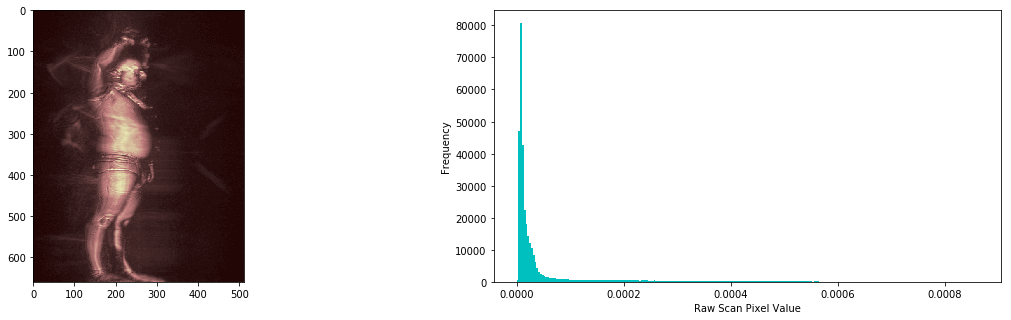

In [86]:
#----------------------------------------------------------------------------------
# get_single_image(infile, nth_image):  returns the nth image from the image stack
#
# infile:                              an aps file
#
# returns:                             an image
#----------------------------------------------------------------------------------

def get_single_image(infile, nth_image):

    # read in the aps file, it comes in as shape(512, 620, 16)
    img = read_data(infile)
    
    # transpose so that the slice is the first dimension shape(16, 620, 512)
    img = img.transpose()
    
    return np.flipud(img[nth_image])

  

# unit test ---------------------------------------------------------------
print (APS_FILE_NAME)
an_img = get_single_image(APS_FILE_NAME, 13)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axarr[0].imshow(an_img, cmap=COLORMAP)
plt.subplot(122)
plt.hist(an_img.flatten(), bins=256, color='c')
plt.xlabel("Raw Scan Pixel Value")
plt.ylabel("Frequency")
plt.show()


Here's the histogram:
![Raw Histogram](https://storage.googleapis.com/kaggle-datasets-jbf/tsa_datasets/raw_hist.png)

*Image output removed at the request of DHS.  Uncomment the unit test and run in your own environment.*

<H3>Rescaling the Image</H3>

Most image preprocessing functions want the image as grayscale.  So here's a function that rescales to the normal grayscale range.

../stage1_aps/052117021fc1396db6bae78ffe923ee4.aps


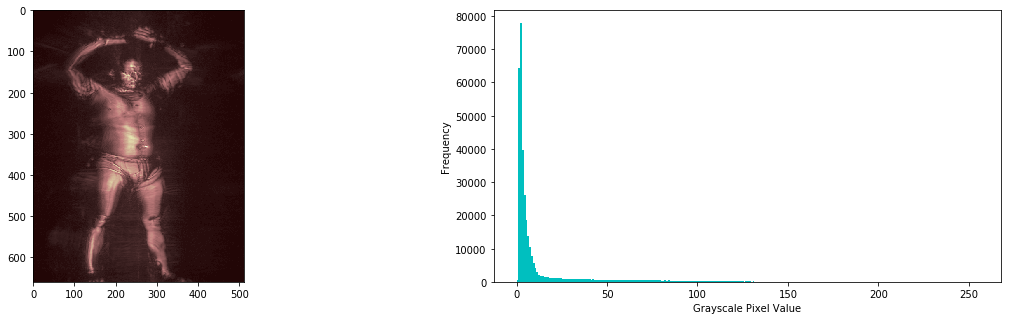

In [34]:
#----------------------------------------------------------------------------------
# convert_to_grayscale(img):           converts a ATI scan to grayscale
#
# infile:                              an aps file
#
# returns:                             an image
#----------------------------------------------------------------------------------
def convert_to_grayscale(img):
    # scale pixel values to grayscale
    base_range = np.amax(img) - np.amin(img)
    rescaled_range = 255 - 0
    img_rescaled = (((img - np.amin(img)) * rescaled_range) / base_range)

    return np.uint8(img_rescaled)

# unit test ------------------------------------------
img_rescaled = convert_to_grayscale(an_img)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

print(APS_FILE_NAME)

axarr[0].imshow(img_rescaled, cmap=COLORMAP)
plt.subplot(122)
plt.hist(img_rescaled.flatten(), bins=256, color='c')
plt.xlabel("Grayscale Pixel Value")
plt.ylabel("Frequency")
plt.show()


Here's the histogram:
![Grayscale Histogram](https://storage.googleapis.com/kaggle-datasets-jbf/tsa_datasets/grayscale_hist.png)

*Image output removed at the request of DHS.  Uncomment the unit test and run in your own environment.*

<H3>Spreading the Spectrum</H3>

From the histogram, you can see that most pixels are found between a value of 0 and and about 25.  The entire range of grayscale values in the scan is less than ~125.  You can also see a fair amount of ghosting or noise around the core image.  Maybe the millimeter wave technology scatters some noise?  Not sure... Anyway, if someone knows what this is caused by, drop a note in the comments.  That said, let's see what we can do to clean the image up.

In the following function, I first threshold the background.  I've played quite a bit with the threshmin setting (12 has worked best so far), but this is obviously a parameter to play with.

Next we equalize the distribution of the grayscale spectrum in this image.  See <A HREF="http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html">this tutorial</A> if you want to learn more about this technique.  But in the main, it redistributes pixel values to a the full grayscale spectrum in order to increase contrast.



/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


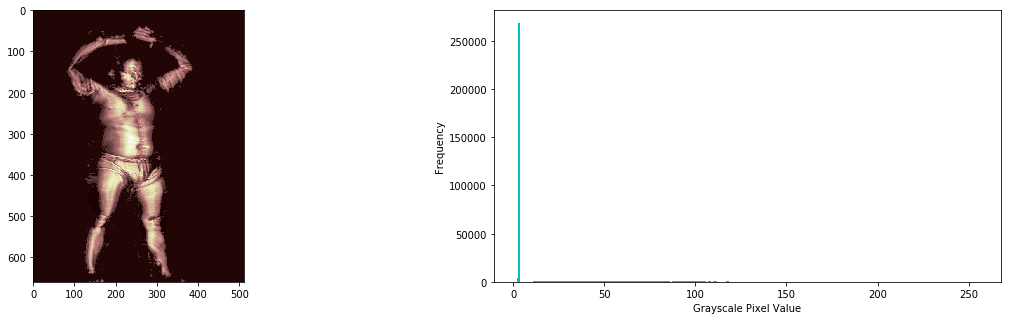

In [35]:
#-------------------------------------------------------------------------------
# spread_spectrum(img):        applies a histogram equalization transformation
#
# img:                         a single scan
#
# returns:                     a transformed scan
#-------------------------------------------------------------------------------

def spread_spectrum(img):
    img = stats.threshold(img, threshmin=12, newval=0)
    
    # see http://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img= clahe.apply(img)
    
    return img
  
# unit test ------------------------------------------
img_high_contrast = spread_spectrum(img_rescaled)

fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

axarr[0].imshow(img_high_contrast, cmap=COLORMAP)
plt.subplot(122)
plt.hist(img_high_contrast.flatten(), bins=256, color='c')
plt.xlabel("Grayscale Pixel Value")
plt.ylabel("Frequency")
plt.show()


Here's the histogram:
![Raw Histogram](https://storage.googleapis.com/kaggle-datasets-jbf/tsa_datasets/spread_spectrum_hist.png)

*Image output removed at the request of DHS.  Uncomment the unit test and run in your own environment.*

In the histogram, you can see that the distribution of pixel values has been spread and all of the noise below 12 has been reduced to 0. The image is cleaner and ready for masking and cropping.  Recall that this subject has contraband in zone 14, and at least to my eye it looks misshapen. 

<H3>Masking the Region of Interest</H3>

Using the slice lists from above, getting a set of masked images for a given threat zone is straight forward.  The same note applies here as in the 4x4 visualization above, I used a cv2.resize to get around a size constraint (see above), therefore the images are quite blurry at this resolution.  Note that the blurriness only applies to the unit test and visualization.  The data returned by this function is at full resolution.


/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


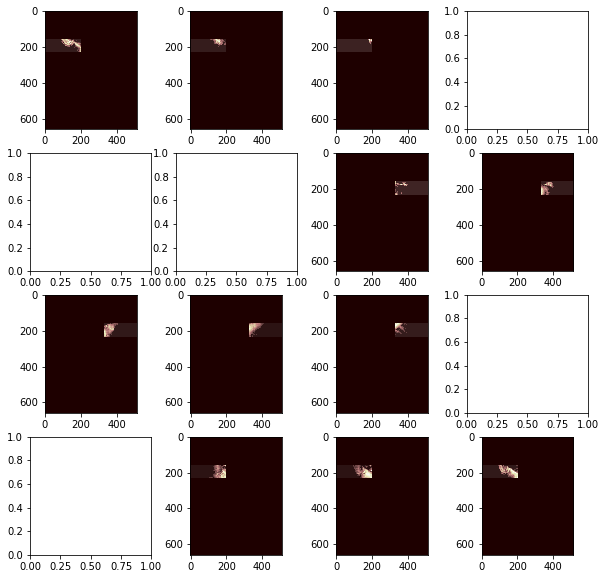

In [26]:
#-----------------------------------------------------------------------------------------
# roi(img, vertices):              uses vertices to mask the image
#
# img:                             the image to be masked
#
# vertices:                        a set of vertices that define the region of interest
#
# returns:                         a masked image
#-----------------------------------------------------------------------------------------
def roi(img, vertices):
    
    # blank mask
    mask = np.zeros_like(img)

    # fill the mask
    cv2.fillPoly(mask, [vertices], 255)

    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    

    return masked
  
# unit test -----------------------------------------------------------------
fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    
i = 0
for row in range(4):
    for col in range(4):
        an_img = get_single_image(APS_FILE_NAME, i)
        img_rescaled = convert_to_grayscale(an_img)
        img_high_contrast = spread_spectrum(img_rescaled)
        if zone_slice_list[0][i] is not None:
            masked_img = roi(img_high_contrast, zone_slice_list[0][i])
            resized_img = masked_img #cv2.resize(masked_img, (0,0), fx=0.1, fy=0.1)
            axarr[row, col].imshow(resized_img, cmap=COLORMAP)
        i += 1


*Image output removed at the request of DHS.  Uncomment the unit test and run in your own environment.*

<H3>Cropping the Images</H3>

Using the crop lists from above, getting a set of cropped images for a given threat zone is also straight forward.  The same note applies here as in the 4x4 visualization above, I used a cv2.resize to get around a size constraint (see above), therefore the images are quite blurry at this resolution.  If you do not face this size constraint, drop the resize.  Note that the blurriness only applies the unit test and visualization.  The data returned by this function is at full resolution.

../stage1_aps/052117021fc1396db6bae78ffe923ee4.aps


/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


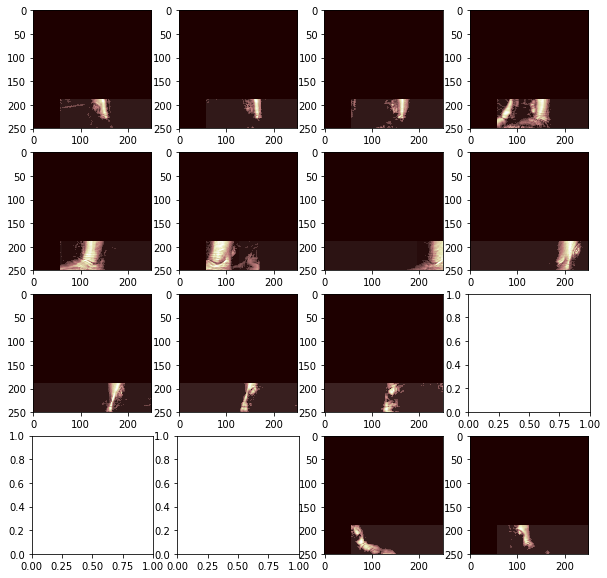

In [39]:
#-----------------------------------------------------------------------------------------
# crop(img, crop_list):                uses vertices to mask the image
#
# img:                                 the image to be cropped
#
# crop_list:                           a crop_list entry with [x , y, width, height]
#
# returns:                             a cropped image
#-----------------------------------------------------------------------------------------
def crop(img, crop_list):

    x_coord = crop_list[0]
    y_coord = crop_list[1]
    width = crop_list[2]
    height = crop_list[3]
    cropped_img = img[x_coord:x_coord+width, y_coord:y_coord+height]
    
    return cropped_img
  
# unit test -----------------------------------------------------------------

fig, axarr = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
    
print(APS_FILE_NAME)
    
tz = 15

    
i = 0
for row in range(4):
    for col in range(4):
        an_img = get_single_image(APS_FILE_NAME, i)
        img_rescaled = convert_to_grayscale(an_img)
        img_high_contrast = spread_spectrum(img_rescaled)
        if zone_slice_list[tz][i] is not None:
            masked_img = roi(img_high_contrast, zone_slice_list[tz][i])
            cropped_img = crop(masked_img, zone_crop_list[tz][i])
            resized_img = cropped_img #cv2.resize(cropped_img, (0,0), fx=0.1, fy=0.1)
            axarr[row, col].imshow(resized_img, cmap=COLORMAP)
        i += 1

*Image output removed at the request of DHS.  Uncomment the unit test and run in your own environment.*

<H3>Normalize and Zero Center</H3>

With the data cropped, we can normalize and zero center.  Note that more work needs to be done to confirm a reasonable pixel mean for the zero center.

In [19]:
#------------------------------------------------------------------------------------------
# normalize(image): Take segmented tsa image and normalize pixel values to be 
#                   between 0 and 1
#
# parameters:      image - a tsa scan
#
# returns:         a normalized image
#
#------------------------------------------------------------------------------------------

def normalize(image):
    MIN_BOUND = 0.0
    MAX_BOUND = 255.0
    
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

#unit test ---------------------
an_img = get_single_image(APS_FILE_NAME, 0)
img_rescaled = convert_to_grayscale(an_img)
img_high_contrast = spread_spectrum(img_rescaled)
masked_img = roi(img_high_contrast, zone_slice_list[0][0])
cropped_img = crop(masked_img, zone_crop_list[0][0])
normalized_img = normalize(cropped_img)
print ('Normalized: length:width -> {:d}:{:d}|mean={:f}'.format(len(normalized_img), len(normalized_img[0]), normalized_img.mean()))
print (' -> type ', type(normalized_img))
print (' -> shape', normalized_img.shape)


Normalized: length:width -> 250:250|mean=0.019011
 -> type  <class 'numpy.ndarray'>
 -> shape (250, 250)


/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


In [20]:
#-------------------------------------------------------------------------------------
# zero_center(image): Shift normalized image data and move the range so it is 0 c
#                     entered at the PIXEL_MEAN
#
# parameters:         image
#
# returns:            a zero centered image
#
#-----------------------------------------------------------------------------------------------------------
def zero_center(image):
     
    PIXEL_MEAN = 0.014327
    
    image = image - PIXEL_MEAN
    return image

#unit test ---------------------
an_img = get_single_image(APS_FILE_NAME, 0)
img_rescaled = convert_to_grayscale(an_img)
img_high_contrast = spread_spectrum(img_rescaled)
masked_img = roi(img_high_contrast, zone_slice_list[0][0])
cropped_img = crop(masked_img, zone_crop_list[0][0])
normalized_img = normalize(cropped_img)
zero_centered_img = zero_center(normalized_img)
print ('Zero Centered: length:width -> {:d}:{:d}|mean={:f}'.format(len(zero_centered_img), len(zero_centered_img[0]), zero_centered_img.mean()))
print ('Conformed: Type ->', type(zero_centered_img), 'Shape ->', zero_centered_img.shape)

Zero Centered: length:width -> 250:250|mean=0.004684
Conformed: Type -> <class 'numpy.ndarray'> Shape -> (250, 250)


/home/james/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  # Remove the CWD from sys.path while we load stuff.


<H3>Wrap Up and Extensions</H3>

With a full set of isolated scans by threat zone that are normalized and zero centered, we can make examples in several ways.  

<ul>
  <li>Each individual view of the threat zone could be treated as an example, thus creating a larger pool to train from.  But of course, the contraband may not be visible in every view of the threat zone</li>
  <li>We could also make threat zone plates that assemble the individual views of a threat zone into a plate.</li>
  <li>To generate additional examples, we could also flip each cropped scan in all 4 directions</li>
  <li>Add noise to the data</li>
</ul>  
 
PS - If you found this notebook helpful, I hope you'll give me an up vote!  

Good luck!